In [15]:
#IMPORTS
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [ ]:
#IMPORT AND VECTORIZE NEW DATASET

path = './custom_dataset/'
import os
import cv2

dir_list = os.listdir(path)

target = [0,1,2,3,4,5,6,7,8,9]

labels = pd.Series([])

for i in range(0,len(dir_list)):
    label = pd.Series([target[i % 10]])
    labels = pd.concat([labels,label])

column_names = []
[column_names.append("pixel"+str(x)) for x in range(0, 784)]

print(column_names)
i = 0
custom_dataset = pd.DataFrame(columns=column_names)
for imagePath in dir_list:
    image = cv2.imread(path+imagePath)
    grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    flattened = grey_image.flatten()

    custom_dataset.loc[i] = flattened
    i += 1

custom_dataset_labeled = custom_dataset.assign(label=labels.reset_index(drop=True))

train, test = train_test_split(custom_dataset_labeled, test_size=0.2, random_state=42, shuffle=True)
X_train_custom = train.loc[:,:'label']
X_test_custom = test.loc[:,:'label']
y_train_custom = train.loc[:,'label']
y_test_custom = test.loc[:,'label']

In [2]:
# BOOSTING IMPLEMENTATION

class AdaBoost():
    def __init__(self, num_iter=500):
        self.num_iter = num_iter
        self.stumps = []
        self.train_error = []
        self.alpha_list = []

    def calculate_error(self, y, y_pred, w):
        err = (sum(w * (np.not_equal(y, y_pred)).astype(int)))/sum(w)
        return err

    def update_weights(self, alpha, w, y, y_pred):
        w = w * np.exp(alpha * (np.not_equal(y, y_pred)).astype(int))
        return w

    def calculate_alpha(self, err):
        return np.log((1-err) / err)

    def fit(self, X, y):
        for i in range(self.num_iter):
            if i == 0:
                w = np.ones(len(y)) * (1 / len(y))
            else:
                w = self.update_weights(alpha, w, y, y_pred)

            base_clf = DecisionTreeClassifier(max_depth=1)

            base_clf.fit(X, y, sample_weight=w)
            y_pred = base_clf.predict(X)

            self.stumps.append(base_clf)

            err = self.calculate_error(y, y_pred, w)
            self.train_error.append(err)

            alpha = self.calculate_alpha(err)
            self.alpha_list.append(alpha)
        return True

    def predict(self, X):
        #store preds
        df_weak = pd.DataFrame(index=range(len(X)), columns=range(self.num_iter))
        for i in range(self.num_iter):
            y_pred = self.stumps[i].predict(X) * self.alpha_list[i]
            df_weak.iloc[:,i] = y_pred

        y_pred = (1 * np.sign(df_weak.T.sum())).astype(int)
        return y_pred

class MultiClassAdaBoost():
    def __init__(self, n_clf=5,num_iter=100):
        self.n_clf = n_clf
        self.num_iter = num_iter
        self.classifiers = {}

    def fit(self, X, y):
        numbers = np.unique(y)
        for i, number in enumerate(numbers):
            binary_y = np.where(y == number, 1, -1)
            boost = AdaBoost(num_iter=self.num_iter)
            boost.fit(X, binary_y)
            self.classifiers[number] = boost

    def predict(self, X):
        predictions = []
        for label, classifier in self.classifiers.items():
            predictions.append(classifier.predict(X))
        predictions = np.array(predictions)
        return np.argmax(predictions, axis=0)

from sklearn.tree import DecisionTreeClassifier
mnist = load_digits()
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.25, random_state=0)


#Defaults
print("Defaults")
model = MultiClassAdaBoost(n_clf=5,num_iter=500)
model.fit(X_train,y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
print("Train Accuracy:",accuracy_score(y_train,y_pred_train))
print("Test Accuracy:",accuracy_score(y_test,y_pred_test))

Defaults
Train Accuracy: 1.0
Test Accuracy: 0.9088888888888889


In [ ]:
#AdaBoost Parameter Testing

num_iter_list = [100,200,300,400,500,600,700,800,900,1000]
bestScore = {"num_iter":0,"accuracy":0}

y_axis = []
for iter in num_iter_list:
    test_clf = MultiClassAdaBoost(num_iter=iter)
    test_clf.fit(X_train,y_train)
    y_pred_comparison = test_clf.predict(X_test)
    print("number of iterations:",iter,"Accuracy:",sklearn.metrics.accuracy_score(y_test,y_pred_comparison))
    if(sklearn.metrics.accuracy_score(y_test, y_pred_comparison) > bestScore["accuracy"]):
        bestScore["num_iter"] = iter
        bestScore["accuracy"] = sklearn.metrics.accuracy_score(y_test, y_pred_comparison)

    y_axis.append(sklearn.metrics.accuracy_score(y_test,y_pred_comparison))
plt.plot(num_iter_list, y_axis)
plt.title("Accuracy per n Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel("Test Accuracy")
plt.show()

print(bestScore)

Recall: 0.9123785949185701
Precision: 0.9307235326480849
F1 Score: 0.9113927288234329
Axes(0.125,0.11;0.62x0.77)


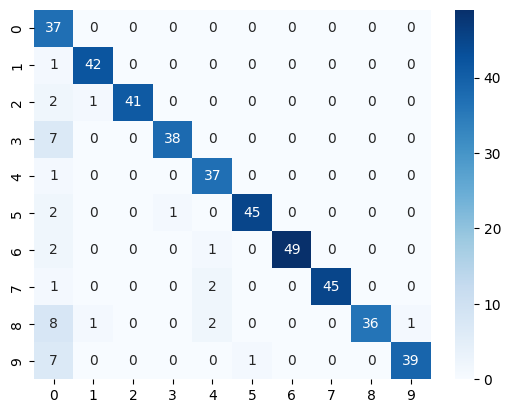

In [14]:
#Other Metrics

print("Recall:",recall_score(y_test,y_pred_test,average="macro"))
print("Precision:",precision_score(y_test,y_pred_test,average="macro"))
print("F1 Score:",f1_score(y_test,y_pred_test,average="macro"))
confusionMatrix = (confusion_matrix(y_test,y_pred_test))
print(sns.heatmap(confusionMatrix, annot=True,cmap="Blues"))